In [2]:
import sys, os
PYTHON = %system which python
HOSTNAME = %system echo $HOSTNAME
print("python dir:     ",PYTHON)
print("HOSTNAME:       ",HOSTNAME)

sys.path.append('/Users/rezvanchitsazi/MachineLearning/Cannabinoid_receptor_1')
from lib import *

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


%load_ext autoreload
%autoreload 2

python dir:      ['/Users/rezvanchitsazi/opt/anaconda3/bin/python']
HOSTNAME:        ['[Rezvans-MacBook-Pro.local]']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)

In [4]:
pwd

'/Users/rezvanchitsazi/MachineLearning/Cannabinoid_receptor_1'

# <font color=darkcyan> Original Data <font> 

In [5]:
pd.set_option('display.max_columns', None)
data=pd.read_csv('cb1.csv', sep=';')
data.to_csv('data.csv', index=False)
data.head(5)
data[['Standard Value','Standard Type']].head(5)

,Standard Value,Standard Type
0,28.8,Ki
1,NaN,EC50
2,10000.0,Ki
3,NaN,Ki
4,NaN,Ki


# <font color=darkcyan> Data Cleaning <font> 

In [6]:
data=pd.read_csv('data.csv', delimiter=',',usecols = ['Molecule ChEMBL ID','Molecular Weight','AlogP','Smiles'] )

data.dropna(subset=['Molecule ChEMBL ID','Molecular Weight','AlogP','Smiles'], inplace=True)
data = data[data['AlogP'].str.contains('None') == False]

data = data.rename(columns={'Molecule ChEMBL ID': 'ChEMBL ID','Molecular Weight':'MW'})

data['AlogP'] = data['AlogP'].astype(float)

In [7]:
data['Smiles'].head(5)

0    Cc1c(C(=O)c2cccc3ccccc23)c2cccc3c2n1[C@H](CN1C...
1    N#Cc1ccccc1CSc1nnc2c3ccccc3n(S(=O)(=O)c3ccccc3...
2    CCCCCn1cc(C(=O)NC2CCCCC2)c(=O)n2nc(-c3ccc(C)cc...
3           FC(F)(F)c1ccccc1CSc1nnc2c(n1)[nH]c1ccccc12
4    COC(=O)[C@H](Cc1ccccc1)NC(=O)c1c(C)n(CCN2CCOCC...
Name: Smiles, dtype: object

# <font color=darkcyan> MolVS <font> 
> ### Molecule Validation and Standardization Tool

In [8]:
data['mol'] = data['Smiles'].apply(lambda x: Chem.MolFromSmiles(x))
print(len(data['mol']))

from molvs import Standardizer
s = Standardizer()
data['mol']=data['mol'].apply(lambda x: s.standardize(x)) 
#data['mol'] = data['mol'].apply(lambda x: Chem.AddHs(x))

#for mol in data['mol'][:5]:
   # Draw.MolToMPL(mol, size=(200,200)) 
   # plt.axis('off')

17674


# <font color=darkcyan> Feature Engineering <font> 
> NOTE: Ghose-Crippen-Viswanadhan octanol-water partition coefficient (MolLogP=ALogP); Sanity-Checked

In [9]:
data.loc[:, 'HAccept'] = data['mol'].apply(Descriptors.NumHAcceptors)
data.loc[:, 'HDonor'] = data['mol'].apply(Descriptors.NumHDonors)
data.loc[:, 'RotableBonds'] = data['mol'].apply(Descriptors.NumRotatableBonds)
data.loc[:, 'RingCount'] = data['mol'].apply(Descriptors.RingCount)
data.loc[:, 'Ipc'] = data['mol'].apply(Descriptors.Ipc)
data.loc[:, 'HallKierAlpha'] = data['mol'].apply(Descriptors.HallKierAlpha)
data.loc[:, 'NumValenceElectrons'] = data['mol'].apply(Descriptors.NumValenceElectrons)
data.loc[:, 'SaturatedRings'] = data['mol'].apply(Descriptors.NumSaturatedRings)
data.loc[:, 'AliphaticRings'] = data['mol'].apply(Descriptors.NumAliphaticRings)
data.loc[:, 'AromaticRings'] = data['mol'].apply(Descriptors.NumAromaticRings)

In [10]:
data.head(3)

,ChEMBL ID,MW,AlogP,Smiles,mol,HAccept,HDonor,RotableBonds,RingCount,Ipc,HallKierAlpha,NumValenceElectrons,SaturatedRings,AliphaticRings,AromaticRings
0,CHEMBL188,426.52,4.60,Cc1c(C(=O)c2cccc3ccccc23)c2cccc3c2n1[C@H](CN1C...,<rdkit.Chem.rdchem.Mol object at 0x7feb6068f3c0>,5,0,4,6,4.782314e+07,-3.15,162,1,2,4
1,CHEMBL3353838,502.54,4.29,N#Cc1ccccc1CSc1nnc2c3ccccc3n(S(=O)(=O)c3ccccc3...,<rdkit.Chem.rdchem.Mol object at 0x7feb606b3eb0>,10,0,6,5,1.162820e+08,-4.34,172,0,0,5
2,CHEMBL3775199,421.55,4.12,CCCCCn1cc(C(=O)NC2CCCCC2)c(=O)n2nc(-c3ccc(C)cc...,<rdkit.Chem.rdchem.Mol object at 0x7feb606b39e0>,6,1,7,4,1.531987e+07,-2.96,164,1,1,3


In [11]:
train_data=data.drop(columns=['Smiles','mol','AlogP','MW','ChEMBL ID'])
y=data['AlogP'].values
train_data.head(3)

,HAccept,HDonor,RotableBonds,RingCount,Ipc,HallKierAlpha,NumValenceElectrons,SaturatedRings,AliphaticRings,AromaticRings
0,5,0,4,6,4.782314e+07,-3.15,162,1,2,4
1,10,0,6,5,1.162820e+08,-4.34,172,0,0,5
2,6,1,7,4,1.531987e+07,-2.96,164,1,1,3


MSE Train:  0.026
MSE Test:  0.18
10.199


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


<Figure size 432x288 with 0 Axes>

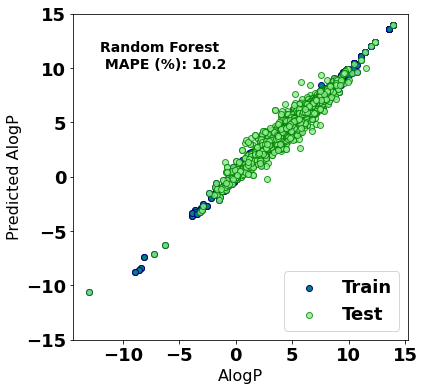

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(train_data, y, test_size=.25, random_state=42)
RF=RandomForestRegressor(random_state=42)


RF.fit(X_train, y_train)

y_pred_test = RF.predict(X_test)
y_pred_train = RF.predict(X_train)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test =  mean_squared_error(y_test, y_pred_test)

print('MSE Train: ', mse_train.round(3))
print('MSE Test: ', mse_test.round(3))

percent_error = np.mean( 100*np.abs(y_test -y_pred_test)/np.abs(y_pred_test))
print(percent_error.round(3))

name='Random Forest'
fulltitle = name+'\n MAPE (%): '+str(round(percent_error,2))

plt.clf()
fontsize=16
plt.figure(figsize=(6,6))
plt.scatter(y_train,y_pred_train, label = 'Train', c='teal', edgecolors='navy')
plt.xlabel('AlogP', fontsize=fontsize)
plt.ylabel('Predicted AlogP', fontsize=fontsize)
plt.scatter(y_test,y_pred_test,c='lightgreen', label='Test', alpha = 0.8, edgecolors='g')
plt.ylim(-15, 15)
plt.text(-12, 10, fulltitle, fontsize=14, bbox=dict(facecolor='white',edgecolor='white',alpha=0.75))
plt.legend(loc=4)
plt.savefig(name+'_2D.png', dpi=2400, bbox_inches='tight')
plt.show();

alpha_grid = {'alpha': np.logspace(1e-11,1e-1,8)}


In [13]:
param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

estimator = RandomForestRegressor()
grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=10)
grid.fit(X_train, y_train)

print(grid.best_estimator_)
print(grid.best_params_)

RandomForestRegressor(max_features='log2', n_estimators=700)
{'max_features': 'log2', 'n_estimators': 700}


In [14]:
RF_tuned=RandomForestRegressor(bootstrap=True, 
                               max_features='sqrt', 
                               n_estimators=700,
                               random_state=42)

MSE Train:  0.024
MSE Test:  0.172
10.823


<Figure size 432x288 with 0 Axes>

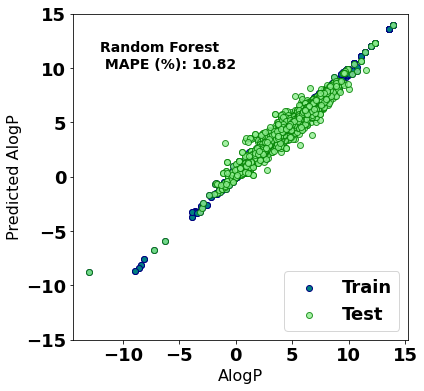

In [15]:
RF_tuned.fit(X_train, y_train)

y_pred_test = RF_tuned.predict(X_test)
y_pred_train = RF_tuned.predict(X_train)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test =  mean_squared_error(y_test, y_pred_test)

print('MSE Train: ', mse_train.round(3))
print('MSE Test: ', mse_test.round(3))

percent_error = np.mean( 100*np.abs(y_test -y_pred_test)/np.abs(y_pred_test))
print(percent_error.round(3))

name='Random Forest'
fulltitle = name+'\n MAPE (%): '+str(round(percent_error,2))

plt.clf()
fontsize=16
plt.figure(figsize=(6,6))
plt.scatter(y_train,y_pred_train, label = 'Train', c='teal', edgecolors='navy')
plt.xlabel('AlogP', fontsize=fontsize)
plt.ylabel('Predicted AlogP', fontsize=fontsize)
plt.scatter(y_test,y_pred_test,c='lightgreen', label='Test', alpha = 0.8, edgecolors='g')
plt.ylim(-15, 15)
plt.text(-12, 10, fulltitle, fontsize=14, bbox=dict(facecolor='white',edgecolor='white',alpha=0.75))
plt.legend(loc=4)
plt.savefig(name+'_2D_tuned.png', dpi=2400, bbox_inches='tight')
plt.show();

alpha_grid = {'alpha': np.logspace(1e-11,1e-1,8)}


# <font color=darkcyan> Morgan Fingerprints <font> 

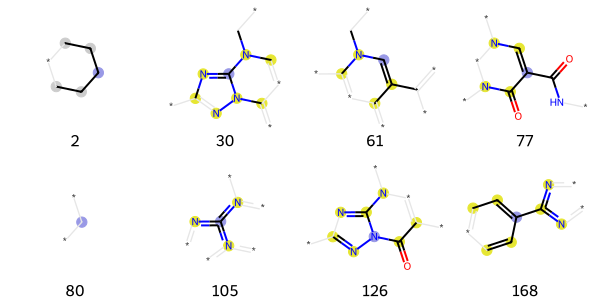

In [16]:
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

fps = {"ECFP4": data['mol'].apply(lambda m: AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=1024)),
       "ECFP6": data['mol'].apply(lambda m: AllChem.GetMorganFingerprintAsBitVect(m, radius=3, nBits=1024))}
fps.keys()


bi = {'bi':1024}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(data['mol'][2], radius=2, bitInfo=bi)

list(fp.GetOnBits())[:8]
tpls = [(data['mol'][2],x,bi) for x in fp.GetOnBits()]
Draw.DrawMorganBits(tpls[:8],molsPerRow=4,legends=[str(x) for x in fp.GetOnBits()][:8])

for f in fps:
    
    X = np.array(fps[f].tolist())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

    estimator = RandomForestRegressor()
    grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)
    grid.fit(X_train, y_train)

    print(grid.best_estimate_)
    print(grid.best_params_)

In [17]:
print(fps.keys())

dict_keys(['ECFP4', 'ECFP6'])


ECFP4
MSE Train:  0.06
MSE Test:  0.27
10.823


<Figure size 432x288 with 0 Axes>

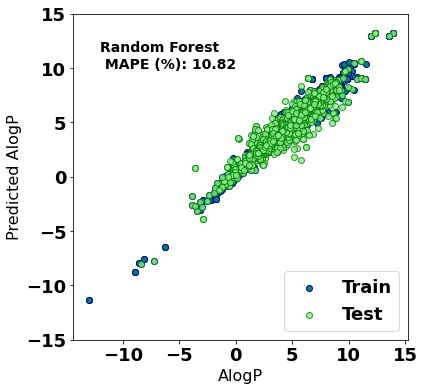

ECFP6
MSE Train:  0.05
MSE Test:  0.28
10.926


<Figure size 432x288 with 0 Axes>

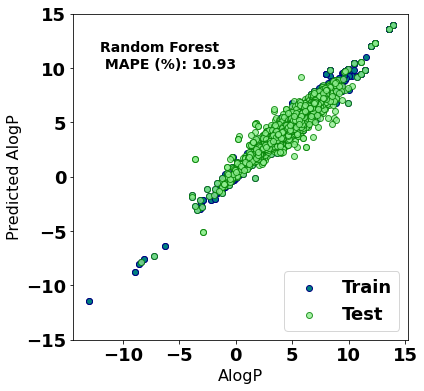

In [18]:
for f in fps:
    print(f)
    X = np.array(fps[f].tolist())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    RF.fit(X_train, y_train)

    y_pred_test = RF.predict(X_test)
    y_pred_train = RF.predict(X_train)

    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test =  mean_squared_error(y_test, y_pred_test)

    print('MSE Train: ', mse_train.round(2))
    print('MSE Test: ', mse_test.round(2))

    '''Mean of Absolute Percent Error (MAPE)'''
    percent_error = np.mean( 100*np.abs(y_test -y_pred_test)/np.abs(y_pred_test))
    print(percent_error.round(3))
    
    name='Random Forest'
    fulltitle = name+'\n MAPE (%): '+str(round(percent_error,2))
   
    plt.clf()
    fontsize=16
    plt.figure(figsize=(6,6))
    plt.scatter(y_train,y_pred_train, label = 'Train', c='teal', edgecolors='navy')
    plt.xlabel('AlogP', fontsize=fontsize)
    plt.ylabel('Predicted AlogP', fontsize=fontsize)
    plt.scatter(y_test,y_pred_test,c='lightgreen', label='Test', alpha = 0.8, edgecolors='g')
    plt.ylim(-15, 15)
    plt.text(-12, 10, fulltitle, fontsize=14, bbox=dict(facecolor='white',edgecolor='white',alpha=0.75))
    plt.legend(loc=4)
    plt.savefig(name+'_'+ f +'.png', dpi=2400,bbox_inches='tight' )
    plt.show();

    alpha_grid = {'alpha': np.logspace(1e-11,1e-1,8)}
    